# Stanton Murillo Transport Validation and Improved XC Correction

[1] "Ionic transport in high-energy-density matter"  [10.1103/PhysRevE.93.043203](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.93.043203)

[2]"Efficient model for electronic transport in high energy-density matter "  [https://doi.org/10.1063/5.0048162](https://doi.org/10.1063/5.0048162)

[3]"Rapid ..." [https:...]

In [20]:
import numpy as np
import matplotlib.pyplot as plt

from pandas import read_csv

import SMT.core.transport as SMT
from SMT.core.physical_constants import *
from SMT.core.physical_parameters import rs_from_n, Degeneracy_Parameter

import matplotlib.pyplot as plt
import matplotlib as mpl

from cycler import cycler


mpl.rcParams['lines.linewidth'] = 2.2
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['font.sans-serif'] = ['Arial', 'Tahoma', 'DejaVu Sans', 'Lucida Grande', 'Verdana']
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.color'] = '#636363'
mpl.rcParams['grid.alpha'] = 0.12
mpl.rcParams['grid.linewidth'] = 0.7
mpl.rcParams['grid.linestyle'] = '-'
mpl.rcParams['axes.prop_cycle'] = cycler('color',  ['#0AB34F', '#bf009f', '#00abc3', '#8e92c5', '#cc7014', '#e32851'])
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.framealpha'] = 0.6
mpl.rcParams['legend.fontsize'] = 10
mpl.rcParams['figure.figsize'] = 8, 4.9443
mpl.rcParams['figure.dpi'] = 100

## Define Useful transport function

In [21]:
def get_transport_functions(Z, A, ni_cc, xc_type=None, λdB=False):

    if xc_type==None:
        smt = SMT.TransportProperties(1, np.array([m_amu*A]), np.array([Z]), np.array([1*eV_to_AU, 1*eV_to_AU ]), np.array([ni_cc])*invcc_to_AU, improved_xc_SMT=False, improved_λdB_SMT=λdB, λdB_n=λdB_n)
    else:
        smt = SMT.TransportProperties(1, np.array([m_amu*A]), np.array([Z]), np.array([1*eV_to_AU, 1*eV_to_AU ]), np.array([ni_cc])*invcc_to_AU, improved_xc_SMT=True, improved_λdB_SMT=λdB, xc_type='PDW', λdB_n=λdB_n)

    # All out in cgs
    @np.vectorize
    def ηSMT(T_eV):
        T_AU = T_eV*eV_to_AU
        smt.T_array = np.array([T_AU, T_AU])
        return smt.viscosity()*AU_to_g*AU_to_invcc*AU_to_cm**2/AU_to_s
    
    @np.vectorize
    def ηYVM(T_eV):
        yvm = YVM(smt.mi_array*AU_to_g, smt.mi_array*AU_to_g*smt.ni_array*AU_to_invcc, T_eV, Z, units_out='cgs')
        return yvm.viscosity_YVM()

    @np.vectorize
    def κiSMT(T_eV):
        T_AU = T_eV*eV_to_AU
        smt.T_array = np.array([T_AU, T_AU])
        return smt.κi* AU_to_erg/(AU_to_cm*AU_to_s*AU_to_K)
 
    @np.vectorize
    def κeSMT(T_eV):
        T_AU = T_eV*eV_to_AU
        smt.T_array = np.array([T_AU, T_AU])
        return smt.κee* AU_to_erg/(AU_to_cm*AU_to_s*AU_to_K)
    
    @np.vectorize
    def σeSMT(T_eV):
        T_AU = T_eV*eV_to_AU
        smt.T_array = np.array([T_AU, T_AU])
        return smt.σ* AU_to_Siemens/AU_to_cm
    
    @np.vectorize
    def λeff(T_eV):
        T_AU = T_eV*eV_to_AU
        smt.T_array = np.array([T_AU, T_AU])
        return smt.λeff

    @np.vectorize
    def λ_params(T_eV):
        T_AU = T_eV*eV_to_AU
        smt.T_array = np.array([T_AU, T_AU])
        λi_eff = 1/np.sqrt(np.sum( 1/(smt.λi_array**2 + smt.ri_eff**2)))
        θ = Degeneracy_Parameter(smt.Te, smt.ne)
        return smt.λe, λi_eff, smt.λdBroglie, smt.rc_array, θ

    return ηSMT, ηYVM, κiSMT, κeSMT, σeSMT, λeff, λ_params


## Electrical Conductivity

First, loading data from [2]

In [22]:
σ_data_e1b_SMT = read_csv("Fig1b_eSMT_σ.txt", delim_whitespace=True, header=1)
σ_data_e1b_LM = read_csv("Fig1b_eSMT_σ_LM.txt", delim_whitespace=True, header=1)
σ_data_e1b_Top = read_csv("Fig1b_eSMT_σ_Top_Other.txt", delim_whitespace=True, header=1)
σ_data_e1b_Bot = read_csv("Fig1b_eSMT_σ_Bot_Other.txt", delim_whitespace=True, header=1)

In [23]:
# H
Element_name = 'H'
Z, A = 1, 1.00784
ρi_gpercc  = 1
ni_cc = ρi_gpercc/(m_amu*A*AU_to_g)

λdB_n = 2

SMT_H_funcs = get_transport_functions(Z,A,ni_cc)
SMTPDW_H_funcs = get_transport_functions(Z,A,ni_cc, xc_type='PDW')
SMTλdB_H_funcs = get_transport_functions(Z,A,ni_cc, λdB = True )
SMTPDWλdB_H_funcs = get_transport_functions(Z,A,ni_cc, λdB = True, xc_type='PDW' )


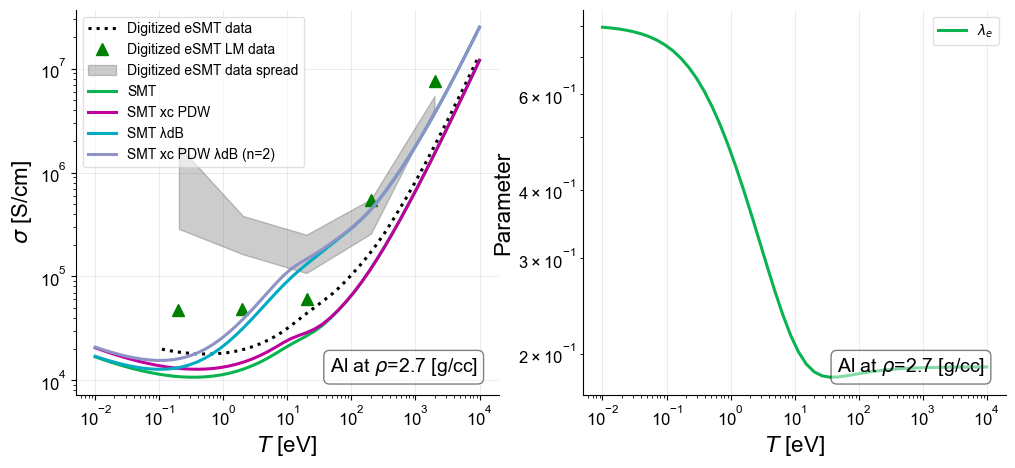

In [59]:
# T_AU_list = np.geomspace(1e-1,1e4,num=100)*eV_to_AU

fig, axs = plt.subplots(1,2, figsize=(12,5), facecolor='white')

ax = axs[0]
# Plot digitized eSMT data
TeV_list = np.geomspace(1e-2,1e4)
ax.plot(σ_data_e1b_SMT['T[eV]'], σ_data_e1b_SMT['σ[S/cm]'],'k:', label="Digitized eSMT data")
ax.plot(σ_data_e1b_LM['T[eV]'], σ_data_e1b_LM['σ[S/cm]'],'g^', label="Digitized eSMT LM data")
ax.fill_between(σ_data_e1b_Top['T[eV]'], σ_data_e1b_Bot['σ[S/cm]'], σ_data_e1b_Top['σ[S/cm]'],color='k',alpha=0.2,label='Digitized eSMT data spread')

ax.plot(TeV_list, SMT_H_funcs[4](TeV_list), label='SMT')
ax.plot(TeV_list, SMTPDW_H_funcs[4](TeV_list), label='SMT xc PDW')
ax.plot(TeV_list, SMTλdB_H_funcs[4](TeV_list), label='SMT λdB')
ax.plot(TeV_list, SMTPDWλdB_H_funcs[4](TeV_list), label=f'SMT xc PDW λdB (n={λdB_n})')
ax.set_ylabel(r"$\sigma$ [S/cm]")

ax = axs[1]
# ax.plot(TeV_list, SMTλdB_H_funcs[6](TeV_list)[3]/SMTλdB_H_funcs[6](TeV_list)[2], label=r'$r_c/\lambda_{dB}$')
ax.plot(TeV_list, SMTλdB_H_funcs[6](TeV_list)[0], label=r'$\lambda_e$')
# ax.plot(TeV_list, SMTλdB_H_funcs[6](TeV_list)[0]/SMTλdB_H_funcs[5](TeV_list), label=r'$\lambda_e/\lambda_{\rm eff}$')
# ax.plot(TeV_list, SMTλdB_H_funcs[6](TeV_list)[1]/SMTλdB_H_funcs[5](TeV_list), label=r'$\lambda_i^{\rm eff}/\lambda_{\rm eff}$')
# ax.plot(TeV_list, SMTPDWλdB_H_funcs[4](TeV_list)/SMT_H_funcs[4](TeV_list), label=r'$\sigma(PDW+\lambda_{dB})/\sigma$')
# ax.plot(TeV_list, SMTλdB_H_funcs[6](TeV_list)[4], label=r'$\theta$')
ax.set_ylabel("Parameter")

for ax in axs:
    ax.set_xlabel(r"$T$ [eV]")
    
    # Inset Text Box
    bbox = dict(boxstyle='round', facecolor='white', alpha=0.5)
    inset_text = f"{Element_name} at " r"$\rho$" + f"={ρi_gpercc} [g/cc]" 
    ax.text(0.6, 0.1, inset_text, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=bbox)
    
    # Scales
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    # Legend
    ax.legend()



## Thermal Conductivity

#### SMT

In [31]:
κ_data_e3b = read_csv("Fig3b_eSMT_κ.txt", delim_whitespace=True, header=1)

In [32]:
# H
Element_name = 'H'
Z, A = 1, 1.00784
ρi_gpercc  = 1
ni_cc = ρi_gpercc/(m_amu*A*AU_to_g)

λdB_n = 2

SMT_H_funcs = get_transport_functions(Z,A,ni_cc)
SMTPDW_H_funcs = get_transport_functions(Z,A,ni_cc, xc_type='PDW')
SMTλdB_H_funcs = get_transport_functions(Z,A,ni_cc, λdB = True )
SMTPDWλdB_H_funcs = get_transport_functions(Z,A,ni_cc, λdB = True, xc_type='PDW' )


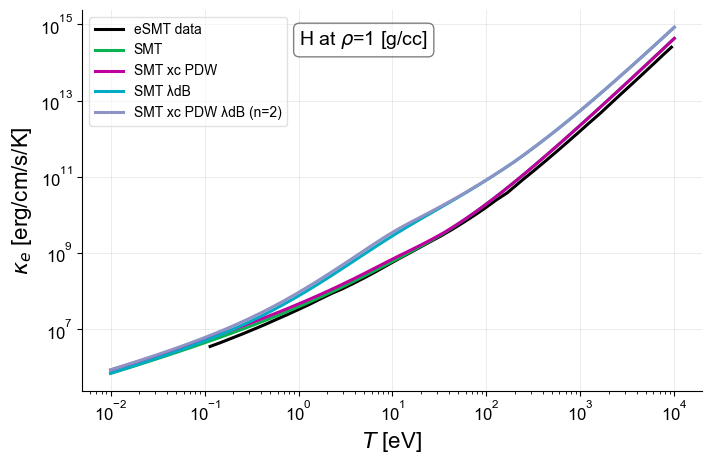

In [33]:
fig, ax = plt.subplots( facecolor='white')

# Plot digitized eSMT data
ax.plot(κ_data_e3b['T[eV]'], κ_data_e3b['κ[erg/cm/s/K]'],'k-', label="eSMT data")

ax.plot(TeV_list, SMT_H_funcs[3](TeV_list), label='SMT')
ax.plot(TeV_list, SMTPDW_H_funcs[3](TeV_list), label='SMT xc PDW')
ax.plot(TeV_list, SMTλdB_H_funcs[3](TeV_list), label='SMT λdB')
ax.plot(TeV_list, SMTPDWλdB_H_funcs[3](TeV_list), label=f'SMT xc PDW λdB (n={λdB_n})')


# Inset Text Box
bbox = dict(boxstyle='round', facecolor='white', alpha=0.5)
inset_text = f"{Element_name} at " r"$\rho$" + f"={ρi_gpercc} [g/cc]" 
ax.text(0.35, 0.95, inset_text, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=bbox)

ax.set_ylabel(r"$\kappa_e$ [erg/cm/s/K]")
ax.set_xlabel(r"$T$ [eV]")

# Scales
ax.set_yscale('log')
ax.set_xscale('log')

# Legend
ax.legend()


In [39]:
# H
Element_name = 'Al'
Z, A = 13, 26.981539
ρi_gpercc  = 2.7
ni_cc = ρi_gpercc/(m_amu*A*AU_to_g)

λdB_n = 2

SMT_Al_funcs = get_transport_functions(Z,A,ni_cc)
SMTPDW_Al_funcs = get_transport_functions(Z,A,ni_cc, xc_type='PDW')
SMTλdB_Al_funcs = get_transport_functions(Z,A,ni_cc, λdB = True )
SMTPDWλdB_Al_funcs = get_transport_functions(Z,A,ni_cc, λdB = True, xc_type='PDW' )


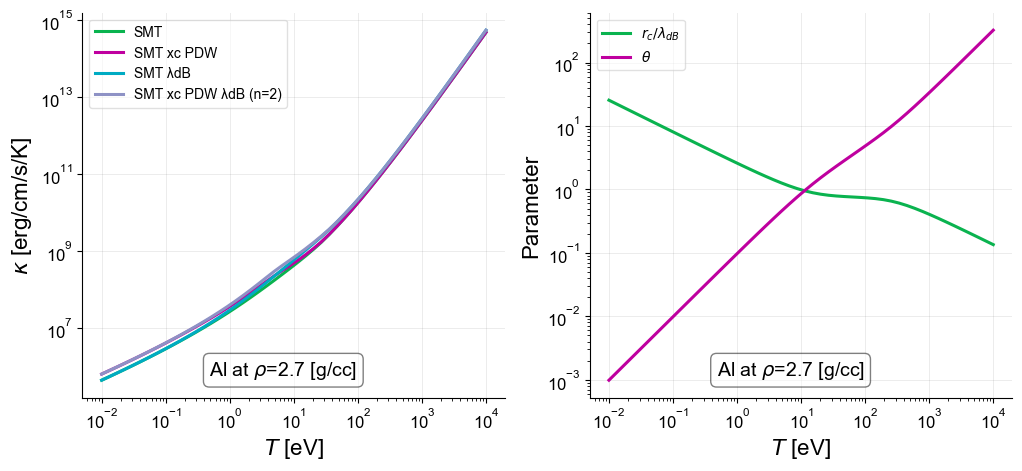

In [57]:
fig, axs = plt.subplots(1,2, figsize=(12,5), facecolor='white')

# Plot digitized eSMT data
# ax.plot(κ_data_e3b['T[eV]'], κ_data_e3b['κ[erg/cm/s/K]'],'k-', label="eSMT data")
ax = axs[0]
TeV_list = np.geomspace(1e-2,1e4)

ax.plot(TeV_list, SMT_Al_funcs[3](TeV_list), label='SMT')
ax.plot(TeV_list, SMTPDW_Al_funcs[3](TeV_list), label='SMT xc PDW')
ax.plot(TeV_list, SMTλdB_Al_funcs[3](TeV_list), label='SMT λdB')
ax.plot(TeV_list, SMTPDWλdB_Al_funcs[3](TeV_list), label=f'SMT xc PDW λdB (n={λdB_n})')
ax.set_ylabel(r"$\kappa$ [erg/cm/s/K]")

ax = axs[1]
ax.plot(TeV_list, SMTλdB_Al_funcs[6](TeV_list)[3]/SMTλdB_Al_funcs[6](TeV_list)[2], label=r'$r_c/\lambda_{dB}$')
# ax.plot(TeV_list, SMTλdB_Al_funcs[6](TeV_list)[0]/SMTλdB_Al_funcs[5](TeV_list), label=r'$\lambda_e/\lambda_{\rm eff}$')
# ax.plot(TeV_list, SMTλdB_Al_funcs[6](TeV_list)[1]/SMTλdB_Al_funcs[5](TeV_list), label=r'$\lambda_i^{\rm eff}/\lambda_{\rm eff}$')
# ax.plot(TeV_list, SMTPDWλdB_Al_funcs[4](TeV_list)/SMT_Al_funcs[4](TeV_list), label=r'$\sigma(PDW+\lambda_{dB})/\sigma$')
ax.plot(TeV_list, SMTλdB_Al_funcs[6](TeV_list)[4], label=r'$\theta$')
ax.set_ylabel("Parameter")

for ax in axs:

    ax.set_xlabel(r"$T$ [eV]")
    
    # Scales
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    # Legend
    ax.legend()
    # Inset Text Box
    bbox = dict(boxstyle='round', facecolor='white', alpha=0.5)
    inset_text = f"{Element_name} at " r"$\rho$" + f"={ρi_gpercc} [g/cc]" 
    ax.text(0.3, 0.1, inset_text, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=bbox)

